In [155]:
import janitor
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn')

In [300]:
# Import hires data

hires = (
    pd.read_csv('data/cycle_hires/179JourneyDataExtract11Sep2019-17Sep2019.csv')
    .clean_names()
    .dropna()
    .drop_duplicates()
    .remove_columns(['rental_id', 'duration', 'bike_id'])
    .to_datetime('end_date', format='%d/%m/%Y %H:%M')
    .to_datetime('start_date', format='%d/%m/%Y %H:%M')
)

print(hires.shape)
hires.head()

(249189, 6)


,end_date,endstation_id,endstation_name,start_date,startstation_id,startstation_name
0,2019-09-11 13:25:00,125,"Borough High Street, The Borough",2019-09-11 13:21:00,10,"Park Street, Bankside"
1,2019-09-15 15:39:00,532,"Jubilee Plaza, Canary Wharf",2019-09-15 14:59:00,237,"Dock Street, Wapping"
2,2019-09-13 22:04:00,715,"Aylward Street, Stepney",2019-09-13 21:56:00,444,"Bethnal Green Garden, Bethnal Green"
3,2019-09-13 13:55:00,715,"Aylward Street, Stepney",2019-09-13 13:46:00,444,"Bethnal Green Garden, Bethnal Green"
4,2019-09-15 17:56:00,648,"Peterborough Road, Sands End",2019-09-15 17:50:00,671,"Parsons Green Station, Parsons Green"


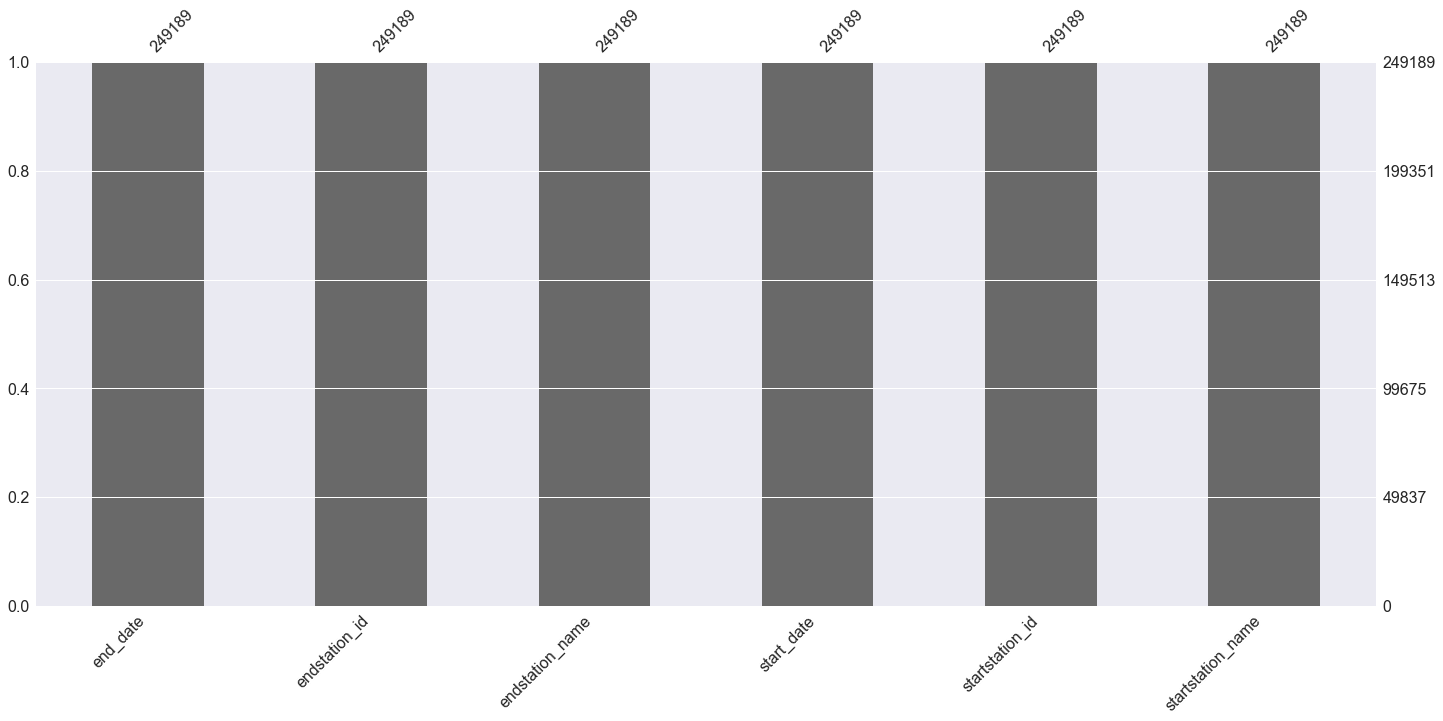

In [301]:
# Visualise missings

import missingno as msno
msno.bar(hires);

In [302]:
# Load station locations data

import geopandas as gpd
import requests
from xml.etree import ElementTree as ET


url = "https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml"

response = requests.get(url)
root = ET.fromstring(response.content)

ids = [int(root[i][0].text) for i in range(0, len(root))]
names = [root[i][1].text for i in range(0, len(root))]
lats = [float(root[i][3].text) for i in range(0, len(root))]
lons = [float(root[i][4].text) for i in range(0, len(root))]
capacities = [int(root[i][12].text) for i in range(0, len(root))]

df = pd.DataFrame(list(zip(ids, names, lats, lons, capacities)),
                        columns=['id', 'name', 'longitude', 'latitude', 'capacity'])

stations = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.latitude, df.longitude))
stations.crs = {'init' :'epsg:4326'}
stations.drop(columns=['longitude', 'latitude'], inplace=True)

print(stations.shape)
stations.head()


(786, 4)


,id,name,capacity,geometry
0,1,"River Street , Clerkenwell",19,POINT (-0.10997 51.52916)
1,2,"Phillimore Gardens, Kensington",37,POINT (-0.19757 51.49961)
2,3,"Christopher Street, Liverpool Street",32,POINT (-0.08461 51.52128)
3,4,"St. Chad's Street, King's Cross",23,POINT (-0.12097 51.53006)
4,5,"Sedding Street, Sloane Square",27,POINT (-0.15688 51.49313)


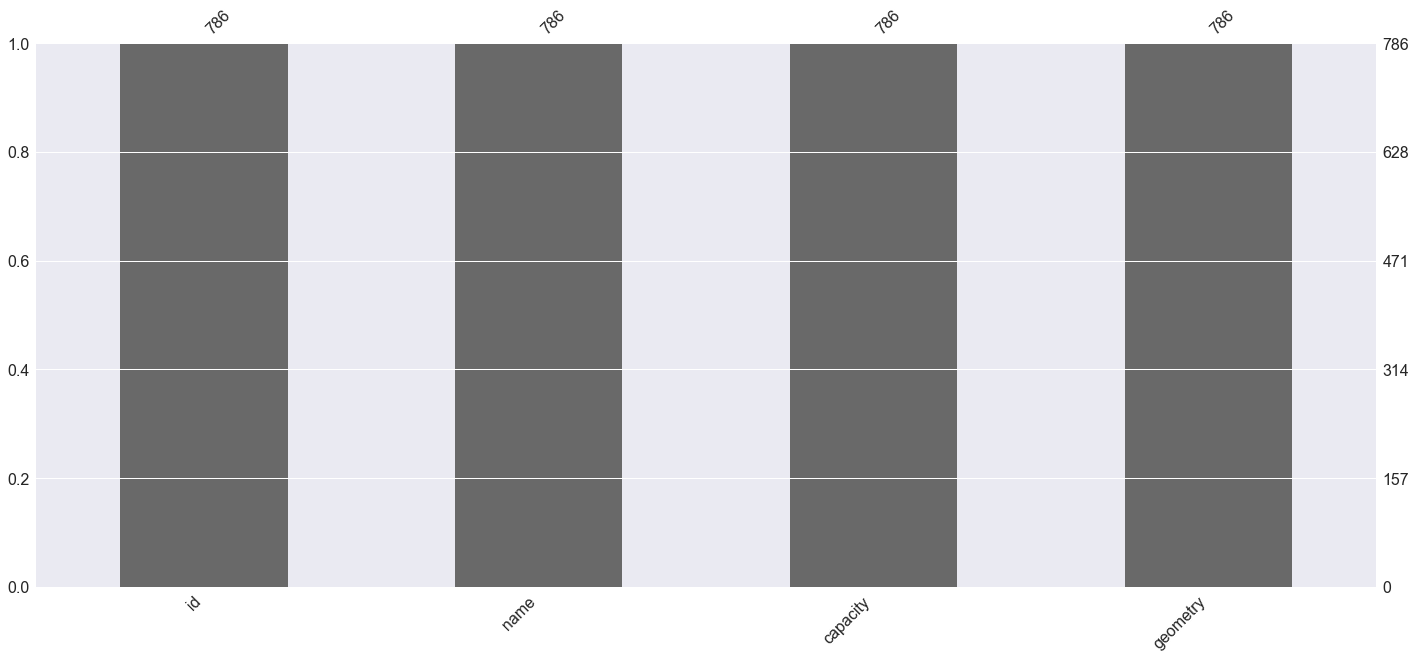

In [303]:
# Check for missings

msno.bar(stations);

In [304]:
# Add capacities to hires data
hires = (
    hires
    .merge(stations, left_on='startstation_id', right_on='id')
    .drop(columns=['id', 'name'])
    .rename(columns={'capacity':'startstation_capacity'})
)
hires = (
    hires
    .merge(stations, left_on='endstation_id', right_on='id')
    .drop(columns=['id', 'name', 'geometry_y'])
    .rename(columns={'capacity':'endstation_capacity',
                     'geometry_x':'geometry'})
)
hires.head()

,end_date,endstation_id,endstation_name,start_date,startstation_id,startstation_name,startstation_capacity,geometry,endstation_capacity
0,2019-09-11 13:25:00,125,"Borough High Street, The Borough",2019-09-11 13:21:00,10,"Park Street, Bankside",18,POINT (-0.09275 51.50597),21
1,2019-09-12 20:22:00,125,"Borough High Street, The Borough",2019-09-12 19:41:00,10,"Park Street, Bankside",18,POINT (-0.09275 51.50597),21
2,2019-09-14 12:43:00,125,"Borough High Street, The Borough",2019-09-14 12:16:00,444,"Bethnal Green Garden, Bethnal Green",24,POINT (-0.05531 51.52568),21
3,2019-09-15 09:47:00,125,"Borough High Street, The Borough",2019-09-15 08:44:00,125,"Borough High Street, The Borough",21,POINT (-0.09452 51.50069),21
4,2019-09-16 16:11:00,125,"Borough High Street, The Borough",2019-09-16 15:32:00,125,"Borough High Street, The Borough",21,POINT (-0.09452 51.50069),21


# Plot station locations

In [152]:
# This would probably be a nicer map background, check out.

# UK maps from https://www.ordnancesurvey.co.uk/opendatadownload/products.html#OPROAD
# buildings = gpd.read_file('data/geo_data/OS OpenMap Local (ESRI Shape File) TQ/TQ_Building.shp')

In [115]:
# Load borough boundaries 

boundaries = get_borough_boundaries().set_index('name')

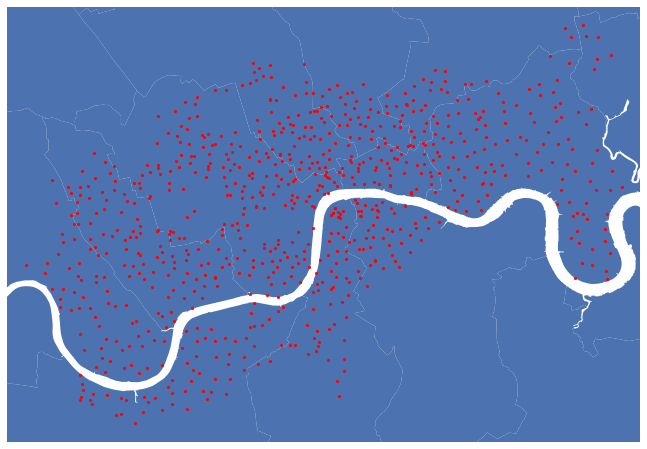

In [116]:
# Plot station locations

from toolbox.toolbox import get_borough_boundaries

# Ensure crs are consistent
stations = stations.to_crs(boundaries.crs)

fig, ax = plt.subplots(1, 1, figsize=(16,8))

xmin = stations['geometry'].bounds.minx.min() - 500
xmax = stations['geometry'].bounds.maxx.max() + 500
ymin = stations['geometry'].bounds.miny.min() - 500
ymax = stations['geometry'].bounds.maxy.max() + 500

base = boundaries.plot(ax=ax)
stations.plot(ax=base, marker='o', color='red', markersize=8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off');

# Plot inflows and outflows

In [218]:
hires['morning'] = hires['start_date'].dt.hour.between(6, 11)
hires['evening'] = hires['start_date'].dt.hour.between(16, 20)
hires = gpd.GeoDataFrame(hires)


In [219]:
am_inflow = hires.dissolve(by=['startstation_id', 'morning'], aggfunc={'startstation_name':'count', 'startstation_capacity':'mean'}).reset_index()
am_inflow['leaving'] = am_inflow['startstation_name'] > am_inflow['startstation_capacity']
am_inflow.head()
am_inflow.crs = {'init' :'epsg:4326'}

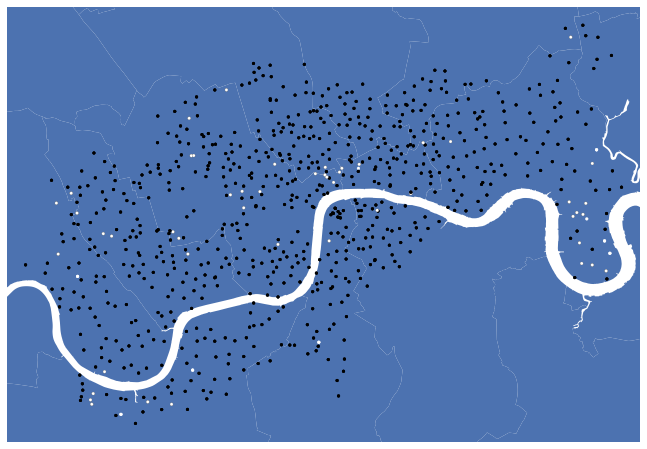

In [220]:
from toolbox.toolbox import get_borough_boundaries

# Ensure crs are consistent
am_inflow = am_inflow.to_crs(boundaries.crs)

fig, ax = plt.subplots(1, 1, figsize=(16,8))

xmin = stations['geometry'].bounds.minx.min() - 500
xmax = stations['geometry'].bounds.maxx.max() + 500
ymin = stations['geometry'].bounds.miny.min() - 500
ymax = stations['geometry'].bounds.maxy.max() + 500

base = boundaries.plot(ax=ax)
am_inflow.plot(ax=base, marker='o', c=am_inflow['leaving'], markersize=8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off');

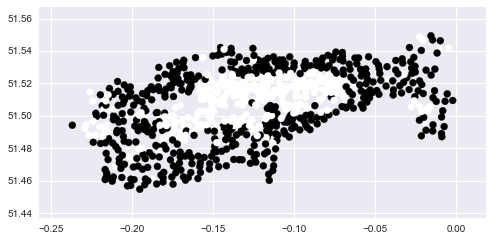

In [315]:

def calc_flows(df):
    outflow = (
        df.groupby('startstation_id')[['start_date']].count()
        .reset_index()
        .rename(columns={'startstation_id':'id', 'start_date':'outflow'})
    )
    inflow = (
        df.groupby('endstation_id')[['end_date']].count()
        .reset_index()
        .rename(columns={'endstation_id':'id', 'end_date':'inflow'})
    )
    return outflow.merge(inflow, on='id', how='inner')


# Calculate morning and evening flows on weekdays

weekdays = hires[hires['start_date'].dt.dayofweek < 5]

mornings = weekdays[weekdays['start_date'].dt.hour.between(6,10)]
morning_flows = calc_flows(mornings)
morning_flows = stations.merge(morning_flows, on='id', how='inner')
morning_flows = morning_flows.set_index('id')
morning_flows['net_outflow'] = morning_flows['outflow'] - morning_flows['inflow'] > 0


evenings = weekdays[weekdays['start_date'].dt.hour.between(16,20)]
evening_flows = calc_flows(evenings)
evening_flows = evening_flows.merge(stations, on='id', how='inner')


# Add flows to station info

morning_flows.plot(c=morning_flows['net_outflow'])

# Old graph

In [1]:
# Load data and combine borough boundaries and profiles

from toolbox.toolbox import get_stations_data
from toolbox.toolbox import get_borough_boundaries
from toolbox.toolbox import get_borough_profiles

stations = get_stations_data()
boundaries = get_borough_boundaries().set_index('name')
profiles = get_borough_profiles().set_index('area_name')

boroughs = boundaries.join(profiles)
boroughs.head()

,geometry,population,average_age,prop_working_age,happiness,anxiety,childhood_obesity_preval,labour_seats
name,,,,,,,,
Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",175400,37.1,67.2,7.4,3.3,16.9,4.2
Croydon,"POLYGON ((535009.200 159504.700, 535005.500 15...",386500,37.0,64.9,7.2,3.3,24.5,57.1
Bromley,"POLYGON ((540373.600 157530.400, 540361.200 15...",327900,40.2,62.6,7.4,3.3,16,11.7
Hounslow,"POLYGON ((521975.800 178100.000, 521967.700 17...",274200,35.8,67.6,7.4,3.4,24.1,81.7
Ealing,"POLYGON ((510253.500 182881.600, 510249.900 18...",351600,36.2,66.8,7.3,3.6,23.8,76.8


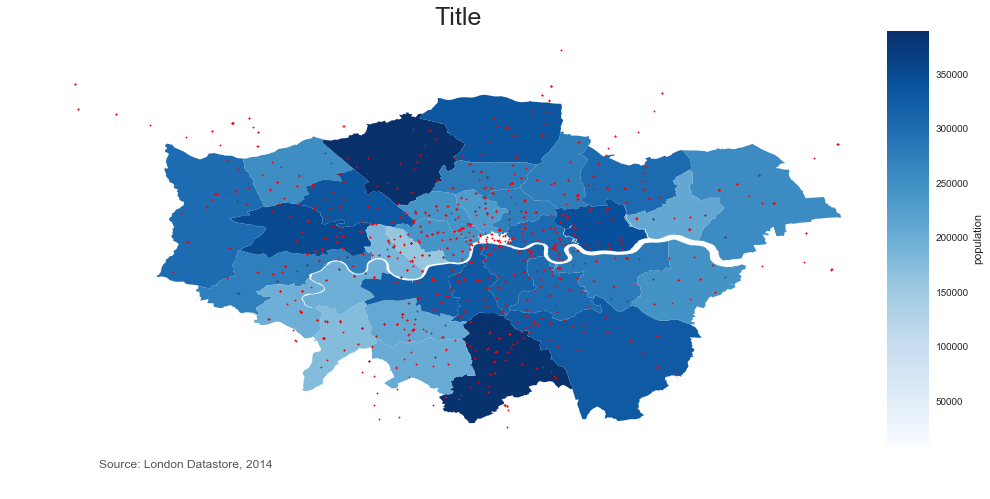

In [6]:
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

variable = 'population'

# Ensure that maps have the same crs
boroughs = boroughs.to_crs(stations.crs)

# Create borough map as base
fig, ax = plt.subplots(1, 1, figsize=(16,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
base = boroughs.plot(column=variable, cmap='Blues', ax=ax, cax=cax,
                     legend=True, legend_kwds={'label':variable})

# Plot stations on top of base
stations.plot(ax=base, marker='o', color='red', markersize=2)

ax.axis('off')
ax.set_title('Title', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  
            fontsize=12, color='#555555',
            xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', );

# Misc.

In [ ]:
# Load cycle hire data from website

url = 'https://cycling.data.tfl.gov.uk/usage-stats/'
csv_list = ['179JourneyDataExtract11Sep2019-17Sep2019.csv']

url_list = [url + f for f in csv_list]
df_list = (pd.read_csv(f) for f in url_list)

df = (
    pd.concat(df_list)
    ...